In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
forecasting = 20

In [4]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [5]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

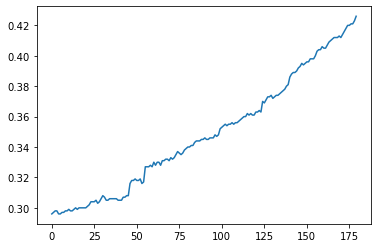

In [6]:
df = df[:180]
df.plot()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

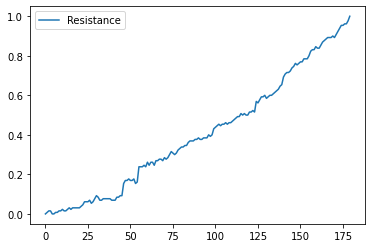

In [8]:
train = df_scaled
train.plot()

In [9]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [11]:
x_train.shape

(128, 20, 1)

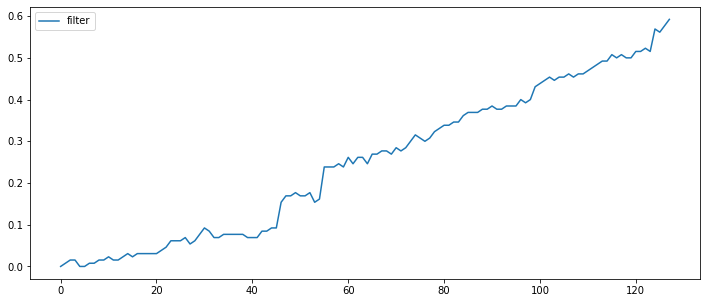

In [12]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

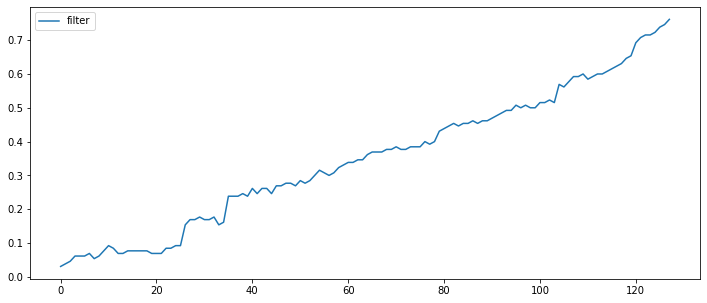

In [13]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [14]:
OUT_STEPS = 20

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 4ms/step - loss: 0.1175 - mean_absolute_error: 0.2839
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1244 - mean_absolute_error: 0.2984
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0989 - mean_absolute_error: 0.2525
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.2295
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0876 - mean_absolute_error: 0.2348
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0659 - mean_absolute_error: 0.1972
Epoch 7/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0529 - mean_absolute_error: 0.1696
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0372 - mean_absolute_error: 0.1434
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0240 - mean_absolute_error: 0.1189
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 3ms/step - loss: 2.4604e-04 - mean_absolute_error: 0.0123
Epoch 74/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2918e-04 - mean_absolute_error: 0.0117
Epoch 75/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.5134e-04 - mean_absolute_error: 0.0126
Epoch 76/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2096e-04 - mean_absolute_error: 0.0116
Epoch 77/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.4887e-04 - mean_absolute_error: 0.0124
Epoch 78/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1910e-04 - mean_absolute_error: 0.0116
Epoch 79/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2210e-04 - mean_absolute_error: 0.0117
Epoch 80/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.2373e-04 - mean_absolute_error: 0.0119
Epoch 81/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.3265e-04 - mean_absolute_er

8/8 [==============================] - 0s 3ms/step - loss: 1.8920e-04 - mean_absolute_error: 0.0108
Epoch 145/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9408e-04 - mean_absolute_error: 0.0108
Epoch 146/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0735e-04 - mean_absolute_error: 0.0113
Epoch 147/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9527e-04 - mean_absolute_error: 0.0109
Epoch 148/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0221e-04 - mean_absolute_error: 0.0111
Epoch 149/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8428e-04 - mean_absolute_error: 0.0105
Epoch 150/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0561e-04 - mean_absolute_error: 0.0113
Epoch 151/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9464e-04 - mean_absolute_error: 0.0110
Epoch 152/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.1444e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.9362e-04 - mean_absolute_error: 0.0108
Epoch 215/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.0211e-04 - mean_absolute_error: 0.0110
Epoch 216/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9574e-04 - mean_absolute_error: 0.0110
Epoch 217/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8726e-04 - mean_absolute_error: 0.0107
Epoch 218/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8516e-04 - mean_absolute_error: 0.0105
Epoch 219/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8302e-04 - mean_absolute_error: 0.0104
Epoch 220/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8990e-04 - mean_absolute_error: 0.0107
Epoch 221/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8380e-04 - mean_absolute_error: 0.0105
Epoch 222/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9690e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7627e-04 - mean_absolute_error: 0.0102
Epoch 286/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8367e-04 - mean_absolute_error: 0.0104
Epoch 287/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9143e-04 - mean_absolute_error: 0.0107
Epoch 288/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8731e-04 - mean_absolute_error: 0.0106
Epoch 289/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6631e-04 - mean_absolute_error: 0.0099
Epoch 290/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9050e-04 - mean_absolute_error: 0.0108
Epoch 291/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8699e-04 - mean_absolute_error: 0.0106
Epoch 292/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7564e-04 - mean_absolute_error: 0.0102
Epoch 293/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8036e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7469e-04 - mean_absolute_error: 0.0103
Epoch 357/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9255e-04 - mean_absolute_error: 0.0108
Epoch 358/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7575e-04 - mean_absolute_error: 0.0103
Epoch 359/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7906e-04 - mean_absolute_error: 0.0103
Epoch 360/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8548e-04 - mean_absolute_error: 0.0107
Epoch 361/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6497e-04 - mean_absolute_error: 0.0099
Epoch 362/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8507e-04 - mean_absolute_error: 0.0105
Epoch 363/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7394e-04 - mean_absolute_error: 0.0102
Epoch 364/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6921e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7985e-04 - mean_absolute_error: 0.0104
Epoch 428/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6837e-04 - mean_absolute_error: 0.0101
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7750e-04 - mean_absolute_error: 0.0103
Epoch 430/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7461e-04 - mean_absolute_error: 0.0103
Epoch 431/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7291e-04 - mean_absolute_error: 0.0101
Epoch 432/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6297e-04 - mean_absolute_error: 0.0098
Epoch 433/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6387e-04 - mean_absolute_error: 0.0100
Epoch 434/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8590e-04 - mean_absolute_error: 0.0106
Epoch 435/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6039e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5215e-04 - mean_absolute_error: 0.0096
Epoch 499/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6942e-04 - mean_absolute_error: 0.0101
Epoch 500/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8640e-04 - mean_absolute_error: 0.0106
Epoch 501/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7560e-04 - mean_absolute_error: 0.0103
Epoch 502/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6729e-04 - mean_absolute_error: 0.0099
Epoch 503/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5658e-04 - mean_absolute_error: 0.0097
Epoch 504/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6255e-04 - mean_absolute_error: 0.0100
Epoch 505/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7212e-04 - mean_absolute_error: 0.0102
Epoch 506/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6737e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5205e-04 - mean_absolute_error: 0.0096
Epoch 570/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5858e-04 - mean_absolute_error: 0.0097
Epoch 571/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6214e-04 - mean_absolute_error: 0.0098
Epoch 572/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4541e-04 - mean_absolute_error: 0.0092
Epoch 573/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6160e-04 - mean_absolute_error: 0.0098
Epoch 574/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4860e-04 - mean_absolute_error: 0.0095
Epoch 575/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6261e-04 - mean_absolute_error: 0.0098
Epoch 576/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5966e-04 - mean_absolute_error: 0.0098
Epoch 577/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6177e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5582e-04 - mean_absolute_error: 0.0096
Epoch 640/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5521e-04 - mean_absolute_error: 0.0094
Epoch 641/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4532e-04 - mean_absolute_error: 0.0093
Epoch 642/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4978e-04 - mean_absolute_error: 0.0094
Epoch 643/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5519e-04 - mean_absolute_error: 0.0095
Epoch 644/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5034e-04 - mean_absolute_error: 0.0095
Epoch 645/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6555e-04 - mean_absolute_error: 0.0100
Epoch 646/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4785e-04 - mean_absolute_error: 0.0093
Epoch 647/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6267e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.5576e-04 - mean_absolute_error: 0.0095
Epoch 711/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3401e-04 - mean_absolute_error: 0.0089
Epoch 712/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3716e-04 - mean_absolute_error: 0.0091
Epoch 713/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4422e-04 - mean_absolute_error: 0.0093
Epoch 714/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5042e-04 - mean_absolute_error: 0.0095
Epoch 715/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5519e-04 - mean_absolute_error: 0.0095
Epoch 716/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5403e-04 - mean_absolute_error: 0.0095
Epoch 717/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6394e-04 - mean_absolute_error: 0.0099
Epoch 718/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4552e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.3966e-04 - mean_absolute_error: 0.0091
Epoch 781/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4817e-04 - mean_absolute_error: 0.0093
Epoch 782/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5974e-04 - mean_absolute_error: 0.0097
Epoch 783/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3492e-04 - mean_absolute_error: 0.0089
Epoch 784/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4421e-04 - mean_absolute_error: 0.0092
Epoch 785/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4970e-04 - mean_absolute_error: 0.0094
Epoch 786/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4058e-04 - mean_absolute_error: 0.0092
Epoch 787/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4761e-04 - mean_absolute_error: 0.0093
Epoch 788/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3558e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.4551e-04 - mean_absolute_error: 0.0093
Epoch 852/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3926e-04 - mean_absolute_error: 0.0090
Epoch 853/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3656e-04 - mean_absolute_error: 0.0090
Epoch 854/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3880e-04 - mean_absolute_error: 0.0090
Epoch 855/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5602e-04 - mean_absolute_error: 0.0094
Epoch 856/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5576e-04 - mean_absolute_error: 0.0095
Epoch 857/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5369e-04 - mean_absolute_error: 0.0096
Epoch 858/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3852e-04 - mean_absolute_error: 0.0090
Epoch 859/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3250e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.3787e-04 - mean_absolute_error: 0.0090
Epoch 922/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2944e-04 - mean_absolute_error: 0.0087
Epoch 923/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3594e-04 - mean_absolute_error: 0.0089
Epoch 924/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3194e-04 - mean_absolute_error: 0.0087
Epoch 925/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3367e-04 - mean_absolute_error: 0.0089
Epoch 926/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4769e-04 - mean_absolute_error: 0.0093
Epoch 927/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5321e-04 - mean_absolute_error: 0.0097
Epoch 928/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4606e-04 - mean_absolute_error: 0.0093
Epoch 929/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5612e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.2679e-04 - mean_absolute_error: 0.0086
Epoch 993/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4084e-04 - mean_absolute_error: 0.0091
Epoch 994/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3469e-04 - mean_absolute_error: 0.0089
Epoch 995/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2964e-04 - mean_absolute_error: 0.0087
Epoch 996/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.2591e-04 - mean_absolute_error: 0.0087
Epoch 997/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3132e-04 - mean_absolute_error: 0.0087
Epoch 998/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3508e-04 - mean_absolute_error: 0.0089
Epoch 999/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.3744e-04 - mean_absolute_error: 0.0088
Epoch 1000/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4362e-04 - mean_ab

num 0 0.4033944209416389 actual 0.7389162561576352 prediction 0.7359355
num 1 5.049814989692283 actual 0.7487684729064039 prediction 0.71095705
num 2 3.10285816005637 actual 0.7536945812807878 prediction 0.77708066
num 3 2.0568292249333124 actual 0.7586206896551722 prediction 0.7742242
num 4 6.961952073451807 actual 0.7684729064039408 prediction 0.8219736
num 5 1.9704494886337642 actual 0.7733990147783252 prediction 0.7581596
num 6 0.0018325033067513338 actual 0.7783251231527091 prediction 0.7783394
num 7 3.262622663809842 actual 0.7832512315270934 prediction 0.80880576
num 8 4.575733467936526 actual 0.7881773399014778 prediction 0.82424223
num 9 6.708504324373987 actual 0.7931034482758621 prediction 0.8463088
num 10 4.960153316274142 actual 0.798029556650246 prediction 0.83761305
num 11 4.534951919390872 actual 0.798029556650246 prediction 0.8342198
num 12 0.9337756328466342 actual 0.8078817733990147 prediction 0.800338
num 13 0.5229902481604757 actual 0.8226600985221673 prediction 0.

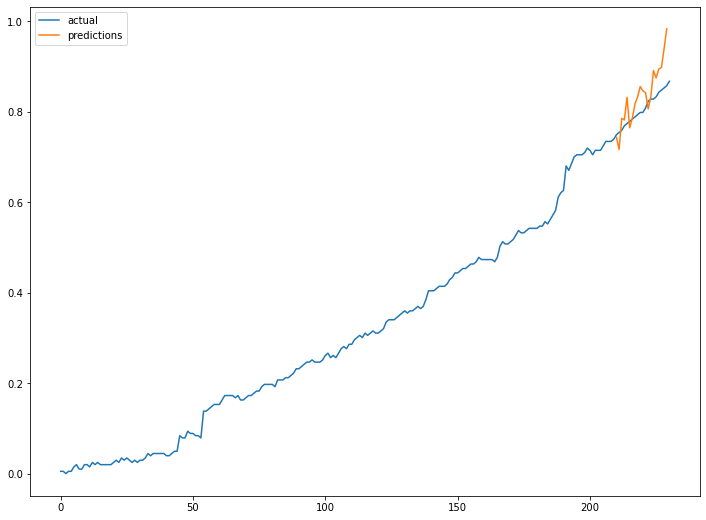

In [17]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.2042226888695767 actual 0.8006535947712417 prediction 0.8022887
num 1 6.549660573082586 actual 0.8104575163398693 prediction 0.7573753
num 2 4.438906692596803 actual 0.8137254901960784 prediction 0.849846
num 3 3.1450433254241963 actual 0.8169934640522876 prediction 0.84268826
num 4 12.014621019363405 actual 0.8169934640522876 prediction 0.91515213
num 5 1.266764122176452 actual 0.8202614379084967 prediction 0.80987066
num 6 2.0545981618255555 actual 0.826797385620915 prediction 0.84378475
num 7 5.413000704720627 actual 0.8366013071895424 prediction 0.88188654
num 8 6.837292573626913 actual 0.8464052287581698 prediction 0.90427643
num 9 9.543631816732491 actual 0.8529411764705881 prediction 0.93434274
num 10 6.2710238046972675 actual 0.8594771241830064 prediction 0.91337514
num 11 5.086698179895249 actual 0.8627450980392155 prediction 0.90663034
num 12 2.2614553289593173 actual 0.8660130718954246 prediction 0.8464286
num 13 1.382831897375741 actual 0.8660130718954246 prediction

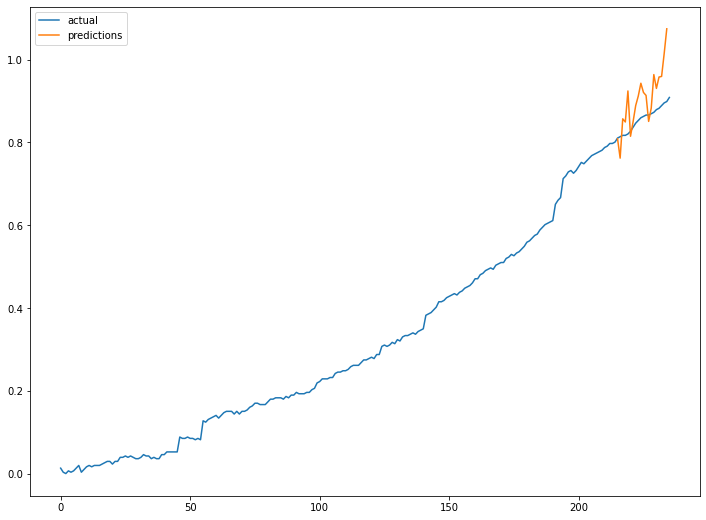

In [18]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.640952367049071 actual 0.6190476190476186 prediction 0.6601583
num 1 0.16845762729635907 actual 0.6666666666666661 prediction 0.6655436
num 2 2.9282438755034366 actual 0.7142857142857135 prediction 0.6933697
num 3 8.971266448497873 actual 0.7619047619047628 prediction 0.69355226
num 4 0.9714400768278973 actual 0.7142857142857135 prediction 0.70734686
num 5 6.196817755699252 actual 0.6666666666666661 prediction 0.7079788
num 6 5.316936969757173 actual 0.6666666666666661 prediction 0.7021129
num 7 9.229823946952918 actual 0.6666666666666661 prediction 0.7281988
num 8 2.3894429206849237 actual 0.7142857142857135 prediction 0.73135316
num 9 3.3465743064881472 actual 0.7142857142857135 prediction 0.7381898
num 10 5.004063844680898 actual 0.7142857142857135 prediction 0.750029
num 11 12.093493342399697 actual 0.6666666666666661 prediction 0.74728996
num 12 5.312523841858022 actual 0.7142857142857135 prediction 0.7522323
num 13 2.4304386228321846 actual 0.7619047619047628 prediction 0

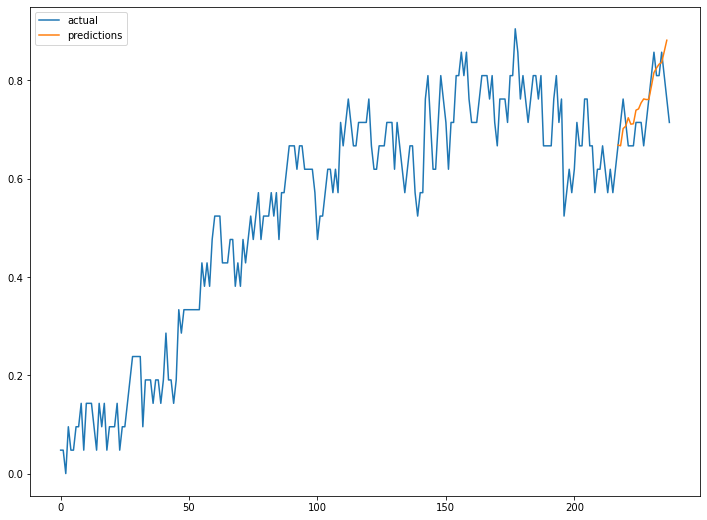

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

214
(235, 20, 1)
num 0 1.7750229154314408 actual 0.6762402088772845 prediction 0.6882436
num 1 1.5584116180737657 actual 0.6892950391644908 prediction 0.678553
num 2 3.957971271950681 actual 0.6971279373368144 prediction 0.72472006
num 3 2.9887492328771654 actual 0.702349869451697 prediction 0.72334135
num 4 6.370108989771901 actual 0.7075718015665795 prediction 0.7526449
num 5 1.2153121024152627 actual 0.7154046997389034 prediction 0.7240991
num 6 0.1995423788665477 actual 0.7284595300261096 prediction 0.7299131
num 7 2.5030944035668217 actual 0.7389033942558747 prediction 0.75739884
num 8 2.328683565717976 actual 0.7493472584856395 prediction 0.7667972
num 9 3.5029601473296963 actual 0.7545691906005221 prediction 0.78100145
num 10 2.3275546653278942 actual 0.7650130548302871 prediction 0.78281915
num 11 1.830013390301028 actual 0.7676240208877285 prediction 0.78167164
num 12 0.003160242320721096 actual 0.7676240208877285 prediction 0.7676483
num 13 1.9468949745165565 actual 0.7780678

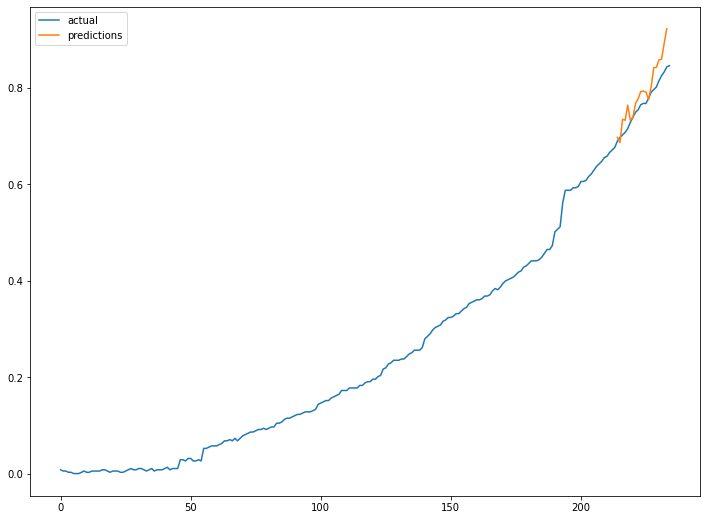

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

print(plot_len)
print(train_feature2.shape)

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 7.603351693404428 actual 0.7916666666666661 prediction 0.85185987
num 1 0.3365868016293925 actual 0.7916666666666661 prediction 0.7943313
num 2 14.143416756077901 actual 0.7916666666666661 prediction 0.9036354
num 3 20.096651713053383 actual 0.75 prediction 0.9007249
num 4 23.658290662263664 actual 0.7916666666666661 prediction 0.97896147
num 5 15.319291750590006 actual 0.75 prediction 0.8648947
num 6 6.966023445129318 actual 0.8333333333333339 prediction 0.8913835
num 7 13.95256996154777 actual 0.8333333333333339 prediction 0.94960475
num 8 5.277874253012985 actual 0.9166666666666661 prediction 0.9650472
num 9 4.224826978600479 actual 0.9583333333333339 prediction 0.99882126
num 10 2.0349564759627 actual 0.9583333333333339 prediction 0.977835
num 11 1.5676830125891015 actual 0.9583333333333339 prediction 0.97335696
num 12 5.4982289024021895 actual 0.9583333333333339 prediction 0.905642
num 13 0.8525620336118565 actual 0.9583333333333339 prediction 0.95016295
num 14 13.2805000651

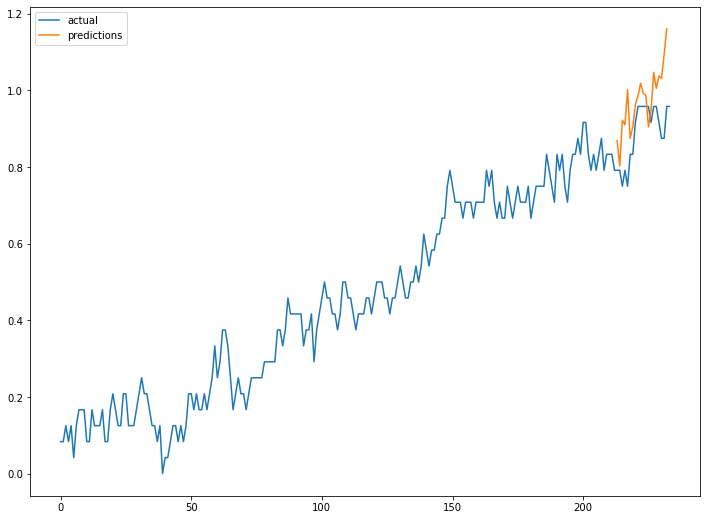

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.6686451560572725 actual 0.8482142857142856 prediction 0.8538858
num 1 7.879907886187194 actual 0.8571428571428568 prediction 0.7896008
num 2 6.7727199353669985 actual 0.8482142857142856 prediction 0.90566146
num 3 4.9667947579429095 actual 0.8526785714285712 prediction 0.89502937
num 4 14.35927853141866 actual 0.8660714285714284 prediction 0.99043304
num 5 3.4801755632672995 actual 0.875 prediction 0.84454846
num 6 1.6630927923367254 actual 0.8794642857142856 prediction 0.8940906
num 7 5.554743627807049 actual 0.8883928571428568 prediction 0.9377408
num 8 9.286442188301503 actual 0.8839285714285712 prediction 0.9660141
num 9 13.063164332404256 actual 0.8883928571428568 prediction 1.0044451
num 10 9.826764193448186 actual 0.8839285714285712 prediction 0.97079015
num 11 7.64371871948243 actual 0.8928571428571428 prediction 0.96110463
num 12 2.8004429127910004 actual 0.901785714285714 prediction 0.8765317
num 13 0.5274608217436692 actual 0.90625 prediction 0.9110301
num 14 11.5489

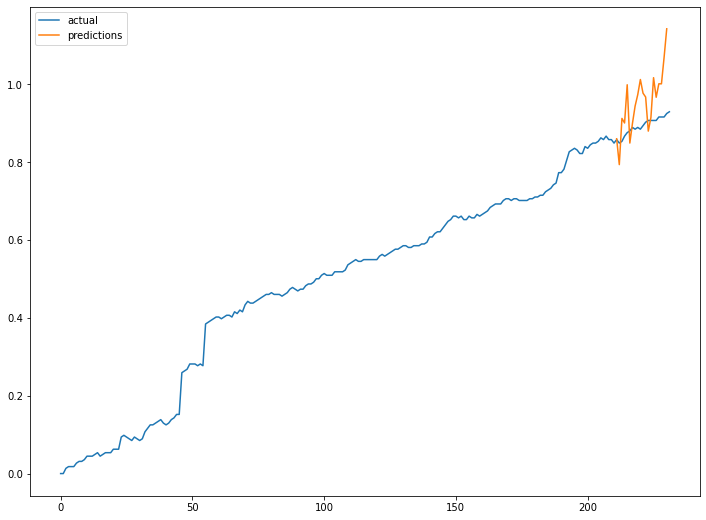

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 22.347230069777673 actual 0.8500000000000014 prediction 0.66004854
num 1 20.954093337059092 actual 0.8000000000000007 prediction 0.63236725
num 2 7.772636413574219 actual 0.75 prediction 0.6917052
num 3 7.002123196919759 actual 0.75 prediction 0.6974841
num 4 1.4186700185139975 actual 0.75 prediction 0.73936
num 5 11.789830525716145 actual 0.75 prediction 0.6615763
num 6 0.25245802743079043 actual 0.7000000000000011 prediction 0.7017672
num 7 2.2632973534718728 actual 0.7000000000000011 prediction 0.7158431
num 8 12.52770974085875 actual 0.6500000000000004 prediction 0.7314301
num 9 8.966231346130204 actual 0.7000000000000011 prediction 0.7627636
num 10 0.4730383555094401 actual 0.75 prediction 0.7464522
num 11 0.31277338663736975 actual 0.75 prediction 0.7476542
num 12 2.340774876730627 actual 0.7000000000000011 prediction 0.7163854
num 13 3.4882409232001774 actual 0.7000000000000011 prediction 0.7244177
num 14 3.4797251224518684 actual 0.8000000000000007 prediction 0.7721622
nu

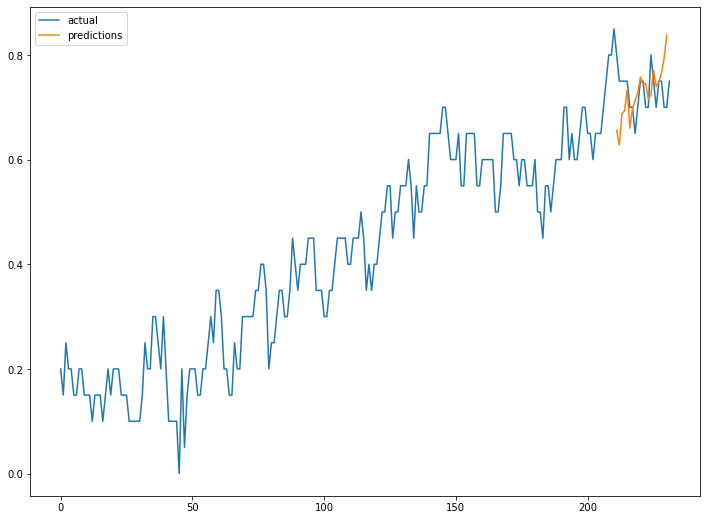

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 22.347230069777673 actual 0.8500000000000014 prediction 0.66004854
num 1 20.954093337059092 actual 0.8000000000000007 prediction 0.63236725
num 2 7.772636413574219 actual 0.75 prediction 0.6917052
num 3 7.002123196919759 actual 0.75 prediction 0.6974841
num 4 1.4186700185139975 actual 0.75 prediction 0.73936
num 5 11.789830525716145 actual 0.75 prediction 0.6615763
num 6 0.25245802743079043 actual 0.7000000000000011 prediction 0.7017672
num 7 2.2632973534718728 actual 0.7000000000000011 prediction 0.7158431
num 8 12.52770974085875 actual 0.6500000000000004 prediction 0.7314301
num 9 8.966231346130204 actual 0.7000000000000011 prediction 0.7627636
num 10 0.4730383555094401 actual 0.75 prediction 0.7464522
num 11 0.31277338663736975 actual 0.75 prediction 0.7476542
num 12 2.340774876730627 actual 0.7000000000000011 prediction 0.7163854
num 13 3.4882409232001774 actual 0.7000000000000011 prediction 0.7244177
num 14 3.4797251224518684 actual 0.8000000000000007 prediction 0.7721622
nu

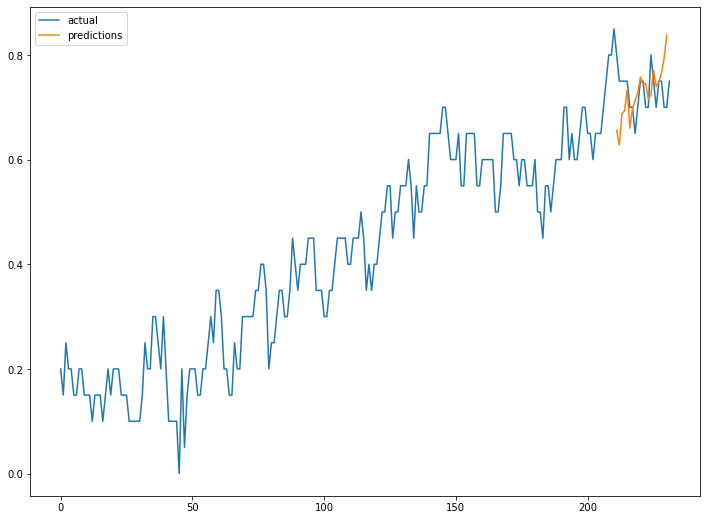

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.606236934661757 actual 0.8421052631578938 prediction 0.820158
num 1 10.713013374444191 actual 0.8684210526315788 prediction 0.775387
num 2 3.2940197736026002 actual 0.8421052631578938 prediction 0.8698444
num 3 1.2579032869049784 actual 0.8684210526315788 prediction 0.85749716
num 4 7.661196679780001 actual 0.8684210526315788 prediction 0.9349525
num 5 1.7778713256119592 actual 0.8421052631578938 prediction 0.8271337
num 6 5.475520703100492 actual 0.8157894736842097 prediction 0.8604582
num 7 10.258508113122863 actual 0.8157894736842097 prediction 0.8994773
num 8 9.825610369444016 actual 0.8421052631578938 prediction 0.92484725
num 9 13.11462521553052 actual 0.8421052631578938 prediction 0.9525442
num 10 7.226561416279209 actual 0.8684210526315788 prediction 0.93117803
num 11 9.277429431676985 actual 0.8421052631578938 prediction 0.920231
num 12 4.29073992897479 actual 0.8947368421052628 prediction 0.856346
num 13 2.660053065328909 actual 0.8684210526315788 prediction 0.8915215

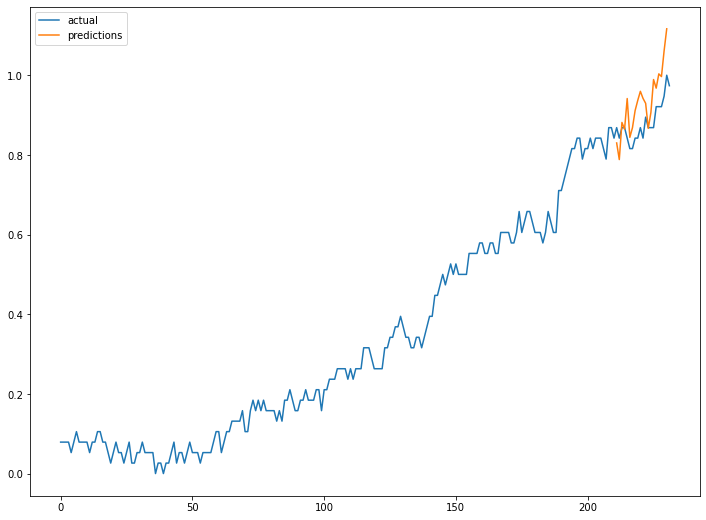

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.763537645340067 actual 0.76923076923077 prediction 0.7325882
num 1 2.3521109631188315 actual 0.7307692307692317 prediction 0.7135807
num 2 5.943544287430473 actual 0.7307692307692317 prediction 0.7742028
num 3 5.121099321465605 actual 0.7307692307692317 prediction 0.76819265
num 4 17.436539464526824 actual 0.6923076923076916 prediction 0.8130222
num 5 1.1381983757020095 actual 0.76923076923077 prediction 0.7604754
num 6 4.091641448793038 actual 0.8076923076923084 prediction 0.77464443
num 7 0.41960023698361054 actual 0.8076923076923084 prediction 0.8043032
num 8 3.0583587559787335 actual 0.8461538461538467 prediction 0.8202754
num 9 3.7598416918799114 actual 0.8076923076923084 prediction 0.83806026
num 10 8.269823193549994 actual 0.76923076923077 prediction 0.8328448
num 11 7.669771313667183 actual 0.76923076923077 prediction 0.828229
num 12 3.7618172168730584 actual 0.76923076923077 prediction 0.7981678
num 13 2.3106830460683776 actual 0.8076923076923084 prediction 0.8263555
n

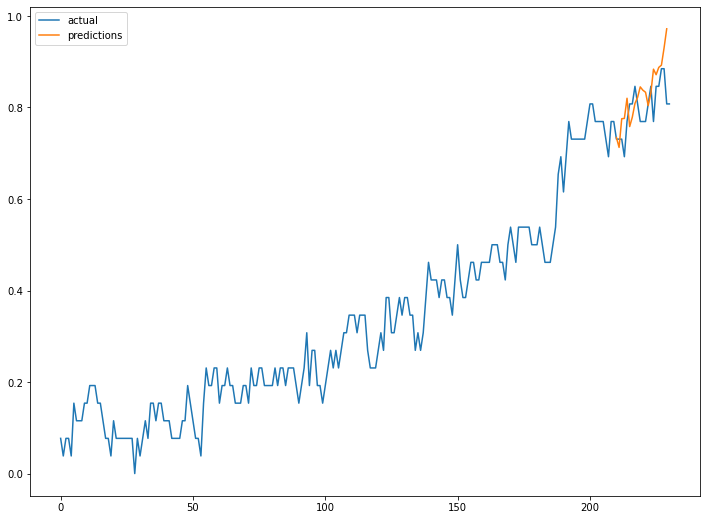

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

x_test2 = test_df['Resistance']


x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()